<a href="https://colab.research.google.com/github/yyyyyYvvvvV/Worldmodel2023_10/blob/Hirai/book/%E4%B8%96%E7%95%8C%E3%83%A2%E3%83%87%E3%83%AB_%E6%9C%80%E7%B5%82%E8%AA%B2%E9%A1%8C_ResVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install h5py

In [12]:
# Google Drive„ÅÆ„Éû„Ç¶„É≥„Éà
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
UTILS_DIR = "/content/drive/MyDrive/‰∏ñÁïå„É¢„Éá„É´/ÊºîÁøíË≥áÊñô/Á¨¨8Âõû/"
# UTILS_DIR = "/workspace/"

In [5]:
# „É©„Ç§„Éñ„É©„É™„ÅÆ„Ç§„É≥„Éù„Éº„Éà
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import math
import json
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
import h5py
from tqdm import tqdm
import torchvision
from torch.utils.data import Dataset

from tqdm.notebook import tqdm
import inspect
import pickle
import pandas as pd

seed = 0
np.random.seed(seed)
torch.manual_seed(seed)

‰ªäÂõû„ÅÆÂ≠¶Áøí„Å´„ÅØGPU„ÅåÂøÖË¶Å„Åß„ÅôÔºéÂøÖË¶Å„Å™„Çâ„Äå„É©„É≥„Çø„Ç§„É†„Äç‚Üí„Äå„É©„É≥„Çø„Ç§„É†„ÅÆ„Çø„Ç§„Éó„ÇíÂ§âÊõ¥„Äç„ÅßGPU„É¢„Éº„Éâ„Å´Â§âÊõ¥„Åó„Åæ„Åó„Çá„ÅÜÔºé

In [6]:
assert torch.cuda.is_available()
device = "cuda"

## 2.„Éá„Éº„Çø„Çª„ÉÉ„Éà„ÅÆÊ∫ñÂÇô

‰ªäÂõû‰ΩøÁî®„Åô„Çã„Éá„Éº„Çø„Çª„ÉÉ„Éà„ÅØÔºåË§áÊï∞„ÅÆÁï∞„Å™„ÇãËâ≤„ÇÑÂΩ¢Áä∂„ÅÆÁâ©‰Ωì„ÅåÁßªÂãï„Åô„Çã[Video-Multi-dSprites (VMDS)](https://github.com/google-deepmind/multi_object_datasets)„Åß„ÅôÔºé`.npy`ÂΩ¢Âºè„ÅßÈÖçÂ∏ÉÊ∏à„Åø„Å™„ÅÆ„ÅßÔºå„Éâ„É©„Ç§„Éñ„Åã„Çâ„Åù„Å°„Çâ„ÇíË™≠„ÅøËæº„Åø„Åæ„ÅôÔºé

In [7]:
class SyntheticDataset(Dataset):
    def __init__(self, split='train', n_steps=10, transform=None):
        """
        ÈÖçÂ∏ÉÊ∏à„Åø„ÅÆVMDS„Éá„Éº„Çø„Çª„ÉÉ„Éà„ÇíË™≠„ÅøËæº„ÅøÔºåDataset„ÇØ„É©„Çπ„ÇíÂàùÊúüÂåñ„Åô„ÇãÔºé

        Parameters
        ----------
        split : str
            {'train', 'val', 'test}
        n_steps : int
            ÂãïÁîª„ÅÆÊúÄÂàù„ÅÆ‰Ωï„Éï„É¨„Éº„É†„Åæ„Åß„Çí‰ΩøÁî®„Åô„Çã„Åã
        transform : torchvision.transforms
            ÂãïÁîª„Å∏„ÅÆÂâçÂá¶ÁêÜ
        """
        self.transform = transform

        imgs = np.load(os.path.join(UTILS_DIR, "lecture08_utils", f"vmds_{split}.npy")) # ( samples, t, c, h, w )
        imgs = imgs[:, :n_steps] # ( samples, n_steps, c, h, w )

        self.imgs = [img for img in imgs]

    def __getitem__(self, index):
        """
        Èâ§Êã¨Âºß[]„ÅßË¶ÅÁ¥†„Å´„Ç¢„ÇØ„Çª„Çπ„Åó„Åü„Å®„Åç„Å´Âëº„Å≥Âá∫„Åï„Çå„ÇãPython„ÅÆÁâπÊÆä„É°„ÇΩ„ÉÉ„Éâ
        „Åì„Åì„ÅßÂãïÁîª„Å´ÂØæ„ÅóÂâçÂá¶ÁêÜ„Çí„Åô„ÇãÂÆüË£Ö„Å´„Å™„Å£„Å¶„ÅÑ„ÇãÔºé

        Parameters
        ----------
        index : int
            „Ç¢„ÇØ„Çª„Çπ„Åï„Çå„ÅüË¶ÅÁ¥†„ÅÆ„Ç§„É≥„Éá„ÉÉ„ÇØ„Çπ

        Returns
        ----------
        x : torch.Tensor ( n_steps, c, h, w )
            „Éá„Éº„Çø„Çµ„É≥„Éó„É´
        """
        x = self.imgs.__getitem__(index)

        if self.transform is not None:
            x = self.transform(x)

        return x

    def __len__(self):
        """ „Ç™„Éñ„Ç∏„Çß„ÇØ„Éà„ÅÆÈï∑„Åï„ÇíËøî„ÅôÔºà„Åì„Åì„Åß„ÅØ„Éá„Éº„Çø„Çª„ÉÉ„Éà„ÅÆ„Çµ„Ç§„Ç∫ÔºâPython„ÅÆÁâπÊÆä„É°„ÇΩ„ÉÉ„Éâ """
        return len(self.imgs)

Ë®ìÁ∑¥ÔºåÊ§úË®ºÔºå„ÉÜ„Çπ„ÉàÁî®„ÅÆ„Éá„Éº„Çø„É≠„Éº„ÉÄ„Éº„Çí„Åù„Çå„Åû„Çå‰ΩúÊàê„Åô„ÇãÈñ¢Êï∞„ÇíÂÆöÁæ©„Åó„Åæ„ÅôÔºé„ÉÜ„Çπ„Éà„Éá„Éº„Çø„É≠„Éº„ÉÄ„Éº„ÅÆ„ÅøÂà•„ÅÆÈñ¢Êï∞„Åß‰ΩúÊàê„Åó„Åæ„ÅôÔºé

In [8]:
def build_dataloader(batch_size, num_workers=1, n_steps=10):
    """
    Ë®ìÁ∑¥„Å®Ê§úË®ºÁî®„ÅÆ„Éá„Éº„Çø„É≠„Éº„ÉÄ„Éº„Çí‰ΩúÊàê„Åô„ÇãÔºé

    Parameters
    ----------
    num_workers : int
        „Éá„Éº„Çø„É≠„Éº„Éá„Ç£„É≥„Ç∞„Å´„ÅÑ„Åè„Å§„ÅÆ„Çµ„Éñ„Éó„É≠„Çª„Çπ„Çí‰Ωø„ÅÜ„Åã
        num_workers=0„Å™„Çâ„Éá„Éº„Çø„É≠„Éº„Éá„Ç£„É≥„Ç∞„ÇÇ„É°„Ç§„É≥„Éó„É≠„Çª„Çπ„ÅßË°å„Çè„Çå„ÇãÔºé
    n_steps : int
        ÂãïÁîª„ÅÆÊúÄÂàù„ÅÆ‰Ωï„Éï„É¨„Éº„É†„Åæ„Åß„Çí‰ΩøÁî®„Åô„Çã„Åã
    dataset_class : str
    """
    kwargs = {'batch_size': batch_size, 'num_workers': num_workers, 'pin_memory': True}

    transform = torchvision.transforms.Lambda(lambda n: n / 255.)

    train_loader = torch.utils.data.DataLoader(
        SyntheticDataset(split='train', n_steps=n_steps, transform=transform),
        shuffle=True,
        **kwargs
    )
    val_loader = torch.utils.data.DataLoader(
        SyntheticDataset(split='val', n_steps=n_steps, transform=transform),
        shuffle=False,
        **kwargs
    )

    return train_loader, val_loader


def build_testloader(batch_size, num_workers=1, n_steps=10):
    """ „ÉÜ„Çπ„ÉàÁî®„ÅÆ„Éá„Éº„Çø„É≠„Éº„ÉÄ„Éº„Çí‰ΩúÊàê„Åô„ÇãÔºé """
    kwargs = {'batch_size': batch_size, 'num_workers': num_workers, 'pin_memory': True}

    transform = torchvision.transforms.Lambda(lambda n: n / 255.)

    test_loader = torch.utils.data.DataLoader(
        SyntheticDataset(split='test', n_steps=n_steps, transform=transform),
        shuffle=True,
        **kwargs
    )

    return test_loader

ÂÆüÈöõ„ÅÆ„Éá„Éº„Çø„ÇíË¶ã„Å¶„Åø„Åæ„Åó„Çá„ÅÜÔºé

In [9]:
def display_video(frames) -> None:
    """
    ‰∏≠Ë∫´„ÇíÂãïÁîª„Åß„Åø„Çã„Åü„ÇÅ„ÅÆÈñ¢Êï∞

    Parameters
    ----------
    frames : List[torch.Tensor]
        ÂèØË¶ñÂåñ„Åô„ÇãÂãïÁîª
    """
    plt.figure(figsize=(8, 8), dpi=50)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])
        plt.title("Step %d" % (i))

    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=50)
    display(HTML(anim.to_jshtml(default_mode='once')))
    plt.close()


config_path = os.path.join(UTILS_DIR, "lecture08_utils", "config.json")

config = json.load(open(config_path))

train_loader, val_loader = build_dataloader(
    batch_size= config['data']['batch_size'],
    num_workers=config['data']['num_workers'],
    n_steps=config['data']['n_steps'],
)

videos = next(iter(train_loader)) # ( batch_size, n_steps, c, h, w )

display_video(list(videos[1].permute(0, 2, 3, 1)))

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [10]:
class ConvEncoder(nn.Module):
    def __init__(self, config):
        super(ConvEncoder, self).__init__()
        self.latent_dim = config['vae']['latent_dim']

        self.g = nn.Sequential(
            nn.Conv2d(4, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True), # Â∞ë„Åó„É°„É¢„É™„ÇíÁØÄÁ¥Ñ„Åß„Åç„Çã„Ç™„Éó„Ç∑„Éß„É≥
            nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Flatten(),
            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 2 * self.latent_dim)
        )

    def forward(self, x):
        mu_logvar = self.g(x)
        return mu_logvar


class BroadcastConvDecoder(nn.Module):
    def __init__(self, config):
        super(BroadcastConvDecoder, self).__init__()
        self.im_size = config['data']['im_size'] + 8
        self.latent_dim = config['vae']['latent_dim']
        self._init_grid()

        self.h = nn.Sequential(
            nn.Conv2d(self.latent_dim + 2, 32, kernel_size=3, stride=1, padding=0),
            # nn.Conv2d(self.latent_dim + 2, self.latent_dim * 2, kernel_size=3, stride=1, padding=0),
            nn.ReLU(True),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=0),
            nn.ReLU(True),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=0),
            nn.ReLU(True),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=0),
            nn.ReLU(True),
            nn.Conv2d(32, 4, kernel_size=1, stride=1, padding=0)
        )

    def _init_grid(self):
        x = torch.linspace(-1, 1, self.im_size)
        y = torch.linspace(-1, 1, self.im_size)
        self.x_grid, self.y_grid = torch.meshgrid(x, y)

    def broadcast(self, z):
        b = z.shape[0]
        x_grid = self.x_grid.expand(b, 1, -1, -1).to(z.device)
        y_grid = self.y_grid.expand(b, 1, -1, -1).to(z.device)
        z_a = z.view((b, -1, 1, 1))
        z_a = z_a.expand(-1, -1, self.im_size, self.im_size)
        z_b = torch.cat((z_a, x_grid, y_grid), dim=1)
        return z_b

    def forward(self, z):
        z_b = self.broadcast(z)
        x = self.h(z_b)
        x_k_mu = x[:, :3]
        m_k_logits = x[:, 3:]
        return x_k_mu, m_k_logits

In [11]:
class AttentionBlock(nn.Module):
    def __init__(self, in_ch, out_ch, resize=True, factor=2., skip=True):
        """
        U-NetÂêÑÂ±§„Å´„ÅÇ„ÇãConv„Éñ„É≠„ÉÉ„ÇØ

        Parameters
        ----------
        in_ch : int
            Áï≥„ÅøËæº„Åø„ÅÆÂÖ•Âäõ„ÉÅ„É£„É≥„Éç„É´Êï∞
        out_ch : int
            Áï≥„ÅøËæº„Åø„ÅÆÂá∫Âäõ„ÉÅ„É£„É≥„Éç„É´Êï∞
        resize : bool
            Up-/ down-sampling„ÇíË°å„ÅÜ„Åã„Å©„ÅÜ„Åã
        factor : float
            Up-/ down-sampling„Åô„Çã„Å®„Åç„ÅÆÂÄçÁéá
        skip : bool
            È†Ü‰ºùÊí≠„Åßskip connectionÁî®„ÅÆTensor„ÇíËøî„Åô„Åã„Å©„ÅÜ„Åã
        """
        super().__init__()

        self._resize = resize
        self._factor = factor
        self._skip = skip

        self.conv = nn.Conv2d(
            in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.inst_norm = nn.InstanceNorm2d(out_ch)
        self.relu = nn.ReLU(inplace=False)

    def forward(self, x):
        """
        Parameters
        ----------
        x : torch.Tensor ( b, c', h', w' )

        Returns
        ----------
        out : torch.Tensor ( b, c'', h'', w'' )
        skip : torch.Tensor ( b, c'', h', w' )
            Skip connectionÁî®„ÅÆ„Éá„Ç≥„Éº„ÉÄ„Éñ„É≠„ÉÉ„ÇØ„Å´Áõ¥Êé•Ê∏°„ÅôTensor
        """
        x = self.conv(x)
        x = self.inst_norm(x)
        out = skip = self.relu(x)

        if self._resize:
            out = F.interpolate(out, scale_factor=self._factor, mode='nearest')

        if self._skip:
            return out, skip
        else:
            return out


class Encoder(nn.Module):
    def __init__(self, block, in_ch, out_ch):
        """
        Attention network (U-Net)„ÅÆ„Ç®„É≥„Ç≥„Éº„ÉÄÈÉ®ÂàÜ

        Parameters
        ----------
        block : AttentionBlock
        in_ch : List[int]
            ÂêÑ„Éñ„É≠„ÉÉ„ÇØ„ÅÆÂÖ•Âäõ„ÉÅ„É£„É≥„Éç„É´Êï∞
        out_ch : List[int]
            ÂêÑ„Éñ„É≠„ÉÉ„ÇØ„ÅÆÂá∫Âäõ„ÉÅ„É£„É≥„Éç„É´Êï∞
        """
        super().__init__()
        assert len(out_ch) == len(in_ch)

        self.n_blocks = len(out_ch)
        self.blocks = nn.ModuleList()

        for i in range(self.n_blocks):
            resize = False if i == self.n_blocks -1 else True
            self.blocks.append(block(in_ch[i], out_ch[i], resize=resize, factor=.5))

    def forward(self, x):
        """
        n_blocksÂÄã„ÅÆ„Éñ„É≠„ÉÉ„ÇØ„Å´ÂÖ•Âäõ„ÇíÈÄö„Åó„Å¶downsampling

        Parameters
        ----------
        x : torch.Tensor ( b, c + 2, im_size, im_size )
            ÂÖ•ÂäõÁîªÂÉèx_t, Ââç„Çπ„ÉÜ„ÉÉ„Éó„ÅÆ‰∫àÊ∏¨„Éû„Çπ„ÇØ\hat{m}_{t,k}Ôºå„Çπ„Ç≥„Éº„Éós_{t,k-1}„Çí
            concat„Åó„Åü„ÇÇ„ÅÆ

        Returns
        ----------
        x : torch.Tensor ( b, c', h', w' )
        skips : List[torch.Tensor]
            Skip connectionÁî®„ÅÆ„Éá„Ç≥„Éº„ÉÄ„Éñ„É≠„ÉÉ„ÇØ„Å´Áõ¥Êé•Ê∏°„ÅôTensor
        """
        skips = []
        for i in range(self.n_blocks):
            x, skip = self.blocks[i](x)
            skips.append(skip)

        return x, skips


class Decoder(nn.Module):
    def __init__(self, block, in_ch, out_ch):
        """
        Attention network (U-Net)„ÅÆ„Éá„Ç≥„Éº„ÉÄÈÉ®ÂàÜ

        Parameters
        ----------
        block : AttentionBlock
        in_ch : List[int]
            ÂêÑ„Éñ„É≠„ÉÉ„ÇØ„ÅÆÂÖ•Âäõ„ÉÅ„É£„É≥„Éç„É´Êï∞
        out_ch : List[int]
            ÂêÑ„Éñ„É≠„ÉÉ„ÇØ„ÅÆÂá∫Âäõ„ÉÅ„É£„É≥„Éç„É´Êï∞
        """
        super().__init__()
        assert len(out_ch) == len(in_ch)

        self.n_blocks = len(out_ch)
        self.blocks = nn.ModuleList()
        for i in range(self.n_blocks):
            resize = False if i == self.n_blocks -1 else True
            self.blocks.append(block(in_ch[i], out_ch[i], resize=resize, factor=2., skip=False))

        # „Éû„Çπ„ÇØÁîªÂÉè„ÅØVAE„Å∏„ÅÆÂÖ•Âäõ„Å®„Åó„Å¶ÊúÄÁµÇÁöÑ„Å´1„ÉÅ„É£„É≥„Éç„É´„Å´„Å™„Çã.
        self.conv = nn.Conv2d(
            out_ch[-1], 1, kernel_size=1, stride=1, padding=0, bias=False
        )

    def forward(self, x, skips):
        """
        n_blocksÂÄã„ÅÆ„Éñ„É≠„ÉÉ„ÇØ„Å´ÂÖ•Âäõ„ÇíÈÄö„Åó„Å¶upsampling

        Parameters
        ----------
        x : torch.Tensor ( b, c', h', w' )
            „Ç®„É≥„Ç≥„Éº„ÉÄ„Å®„Éú„Éà„É´„Éç„ÉÉ„ÇØÈÉ®„ÅÆMLP„ÇíÈÄö„Å£„Å¶„Åç„ÅüË°®Áèæ
        skips : List[torch.Tensor]
            Skip connection

        Returns
        ----------
        x : torch.Tensor ( b, 1, im_size, im_size )
            ÁèæÂú®„Çπ„ÉÜ„ÉÉ„Éó„ÅÆ„Éû„Çπ„ÇØm_{t,k}
        """
        for i in range(self.n_blocks):
            # skips„Åã„ÇâLIFO„ÅßÂèñ„Å£„Å¶„ÅÑ„Åè
            x = torch.cat([x, skips[-(i+1)]], dim=1)
            x = self.blocks[i](x)

        x = self.conv(x)

        return x

class AttentionModule(nn.Module):
    def __init__(self, encoder, decoder, in_ch=5, mlp_ch=256, n_sp=4):
        """
        „Ç®„É≥„Ç≥„Éº„ÉÄ„Å®„Éá„Ç≥„Éº„ÉÄ„Åã„ÇâU-Net„ÇíÊßãÊàê„Åô„ÇãÔºé

        Parameters
        ----------
        encoder : Encoder
        decoder : Decoder
        in_ch : int
            ÂÖ•Âäõ„ÉÅ„É£„É≥„Éç„É´Êï∞ÔºéÂÖ•ÂäõÁîªÂÉèÔºà3„ÉÅ„É£„É≥„Éç„É´ÔºâÔºåÂâç„Çπ„ÉÜ„ÉÉ„Éó„ÅÆ‰∫àÊ∏¨„Éû„Çπ„ÇØÔºà1„ÉÅ„É£„É≥„Éç„É´ÔºâÔºå
            „Çπ„Ç≥„Éº„ÉóÔºà1„ÉÅ„É£„É≥„Éç„É´Ôºâ„Ååconcat„Åï„Çå„Çã„ÅÆ„Åß5
        mlp_ch : int
            „Éú„Éà„É´„Éç„ÉÉ„ÇØÈÉ®„ÅÆMLP„ÇíÈÄö„Å£„ÅüÂæå„ÅÆ„ÉÅ„É£„É≥„Éç„É´Êï∞
        n_sp : int
            „Éá„Ç≥„Éº„ÉÄÂÖ•Âäõ„ÅÆ„Çµ„Ç§„Ç∫
        """
        super().__init__()

        self.in_ch = in_ch
        self.mlp_ch = mlp_ch
        self.n_sp = n_sp
        n_ch = mlp_ch * n_sp * n_sp

        self.encoder = encoder
        self.decoder = decoder

        self.mlp = nn.Sequential(
            nn.Flatten(),
            nn.Linear(n_ch, 128),
            nn.ReLU(True),
            nn.Linear(128, 128),
            nn.ReLU(True),
            nn.Linear(128, n_ch),
            nn.ReLU(True),
        )

    def forward(self, x):
        """
        Parameters
        ----------
        x : torch.Tensor ( b, in_ch (= c + 2), im_size, im_size )
            ÂÖ•ÂäõÁîªÂÉèx_t, Ââç„Çπ„ÉÜ„ÉÉ„Éó„ÅÆ‰∫àÊ∏¨„Éû„Çπ„ÇØ\hat{m}_{t,k}Ôºå„Çπ„Ç≥„Éº„Éós_{t,k-1}„Çí
            concat„Åó„Åü„ÇÇ„ÅÆ

        Returns
        ----------
        x : torch.Tensor ( b, 1, im_size, im_size )
            ÁèæÂú®„Çπ„ÉÜ„ÉÉ„Éó„ÅÆ„Éû„Çπ„ÇØm_{t,k}
        """
        assert x.shape[1] == self.in_ch

        x, skips = self.encoder(x)

        x = self.mlp(x)
        x = x.view(-1, self.mlp_ch, self.n_sp, self.n_sp)

        x = self.decoder(x, skips)
        return x


def create_attn_model(in_ch=5):
    """ U-Net„Å´„Çà„Çãattention network„ÅÆÊßãÁØâ """
    encoder = Encoder(AttentionBlock, [in_ch, 32, 32, 32, 32], [32, 32, 32, 32, 32])
    decoder = Decoder(AttentionBlock, [64, 64, 64, 64, 64], [32, 32, 32, 32, 32])

    model = AttentionModule(encoder, decoder, in_ch, mlp_ch=32, n_sp=4)
    return model

In [12]:
class ViMON(nn.Module):
    def __init__(self, config, attn_module, vae_encoder, vae_decoder, inference=False) -> None:
        super(ViMON, self).__init__()

        self.inference = inference
        self.attn_module = attn_module

        self.n_slots = config['model']['n_slots']
        self.n_steps = config['data']['n_steps'] if inference else config['data']['n_steps'] - 1
        self.latent_dim = config['vae']['latent_dim']
        self.gru_dim = config['gru']['latent_dim']

        # Ê∑∑Âêà„Ç¨„Ç¶„ÇπÂàÜÂ∏É„ÅÆ„Åù„Çå„Åû„Çå„ÅÆÊ®ôÊ∫ñÂÅèÂ∑Æ„ÅØ„ÅÇ„Çâ„Åã„Åò„ÇÅÊ±∫„ÇÅ„Å¶Âõ∫ÂÆöÔºéÊúÄÂàù„ÅÆ„Çπ„É≠„ÉÉ„Éà„ÅØËÉåÊôØ„Å®ÂØæÂøú„Å•„ÅëÔºåÂ∞è„Åï„Åè„Åó„Å¶„Åä„ÅèÔºé
        self.sigma = torch.cat(
            [torch.Tensor([0.09]), torch.Tensor([0.11]).repeat(self.n_slots - 1)]
        )[None, :, None, None, None] # ( 1, n_slots, 1, 1, 1 )

        self.logsoftmax = nn.LogSoftmax(dim=1)
        self.criterion_kl = nn.KLDivLoss(reduction='batchmean')

        self.gru = nn.GRU(self.latent_dim * 2, self.gru_dim, batch_first=True)
        self.mlp = nn.Linear(self.gru_dim, 2 * self.latent_dim)
        self.linear = nn.Linear(self.latent_dim, self.latent_dim)  # Ê¨°„Çπ„ÉÜ„ÉÉ„Éó„ÅÆÊΩúÂú®Â§âÊï∞\hat{z}_{t+1,k}„ÅÆ‰∫àÊ∏¨Áî®
        self.vae_encoder = vae_encoder
        self.vae_decoder = vae_decoder
        # self.deeplabv3_decoder = DeepLabV3Decoder(config)

        self._init_weights()

    def _init_weights(self) -> None:
        """ GRUÔºåÁ∑öÂΩ¢Â±§„ÅÆÈáç„Åø„ÅÆÂàùÊúüÂåñ """
        self.gru.bias_hh_l0.data.fill_(0)
        self.gru.bias_ih_l0.data.fill_(0)
        self.gru.weight_hh_l0.data.normal_(0, 1e-3)
        rand = torch.randn(3 * self.gru_dim, 2 * self.latent_dim) * 1e-3
        eye = rand + torch.cat(
            [torch.zeros(2 * self.gru_dim, 2 * self.latent_dim), torch.eye(self.gru_dim)[:, :2 * self.latent_dim]]
        )
        self.gru.weight_ih_l0.data.copy_(eye)

        self.mlp.apply(self._init_eye)
        self.linear.apply(self._init_eye)

    def _init_eye(self, m) -> None:
        if type(m) == nn.Linear:
            m.bias.data.fill_(0)
            torch.nn.init.eye_(m.weight)

    def reparameterize(self, mu, logvar):
        """
        VAE„ÅÆÂÜç„Éë„É©„É°„Éº„ÇøÂåñ„Éà„É™„ÉÉ„ÇØ

        Parameters
        ----------
        mu : torch.Tensor ( b, latent_dim )
            „Ç¨„Ç¶„ÇπÂàÜÂ∏É„ÅÆÂπ≥Âùá
        logvar : torch.Tensor ( b, latent_dim )
            „Ç¨„Ç¶„ÇπÂàÜÂ∏É„ÅÆÂàÜÊï£„ÅÆÂØæÊï∞

        Returns
        ----------
        z_tk : torch.Tensor ( b, latent_dim )
            ÂæÆÂàÜÂèØËÉΩ„Å™ÂΩ¢„Åß„Ç¨„Ç¶„ÇπÂàÜÂ∏É„Åã„Çâ„Çµ„É≥„Éó„É™„É≥„Ç∞„Åó„ÅüÂÄ§
        """
        if self.inference:
            return mu
        else:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)

            return mu + eps * std

    @staticmethod
    def gauss_prob(preds, targets, sigma):
        """
        „Ç¨„Ç¶„ÇπÂàÜÂ∏É„ÅÆÂ∞§Â∫¶„ÅÆÂÆöÁæ©

        Parameters
        ----------
        preds : torch.Tensor ( b, n_steps or n_steps - 1, n_slots, c, h, w )
            x
        targets : torch.Tensor ( b, n_steps or n_steps - 1, 1, c, h, w )
            mu
        sigma : torch.Tensor ( 1, n_slots, 1, 1, 1 )
            Ê®ôÊ∫ñÂÅèÂ∑Æ

        Returns
        ----------
        prob : torch.Tensor ( b, n_steps or n_steps - 1, n_slots, c, h, w )
        """
        return torch.exp(-torch.pow(preds - targets, 2) / (2 * torch.pow(sigma, 2))) / torch.sqrt(2 * sigma**2 * math.pi)

    @staticmethod
    def kl_div(mu, logvar):
        """
        „Ç¨„Ç¶„ÇπÂàÜÂ∏ÉÔºàÂπ≥ÂùámuÔºåÂàÜÊï£varÔºâ„Å®Âçò‰Ωç„Ç¨„Ç¶„ÇπÂàÜÂ∏ÉÔºàÂπ≥Âùá0ÔºåÂàÜÊï£IÔºâ„ÅÆKL„ÉÄ„Ç§„Éê„Éº„Ç∏„Çß„É≥„Çπ„ÅÆÂÆöÁæ©
        https://leenashekhar.github.io/2019-01-30-KL-Divergence/ „ÅÆÊúÄÂæå„Å™„Å©„ÇíÂèÇÁÖß

        Parameters
        ----------
        mu : torch.Tensor ( b, n_steps, n_slots, latent_dim )
            ‰∫ãÂæåÂàÜÂ∏É„ÅÆÂπ≥Âùá
        logvar : torch.Tensor ( b, n_steps, n_slots, latent_dim )
            ‰∫ãÂæåÂàÜÂ∏É„ÅÆÔºàÂØæÊï∞ÔºâÂàÜÊï£

        Returns
        ----------
        kl_loss : torch.Tensor (, )
        """
        return - 0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=3).mean(dim=(0, 1)).sum()

    def decoder_loglikelihood(self, target, slot_recon, mask_recon):
        """
        „Éá„Ç≥„Éº„ÉÄ„ÅÆÂ∞§Â∫¶ÔºàÊ∑∑Âêà„Ç¨„Ç¶„ÇπÂàÜÂ∏ÉÔºâ„ÅÆÂÆöÁæ©

        Parameters
        ----------
        target : torch.Tensor ( b, n_steps or n_steps - 1, 1, c, h, w )
            ÂÖ•ÂäõÂãïÁîª x_{1:T}„ÅÆÂØæÂøú„Åô„ÇãÈÉ®ÂàÜ
        slot_recon : torch.Tensor ( b, n_steps or n_steps - 1, n_slots, c, h, w )
            VAE Decoder„ÅÆÂá∫ÂäõÔºàÂÖ®„Çπ„É≠„ÉÉ„ÉàÔºâ
        mask_recon : torch.Tensor ( b, n_steps or n_steps - 1, n_slots, 1, h, w )

        Returns
        ----------
        recon_loss : torch.Tensor (, )
            x_t„ÅÆÂÜçÊßãÊàêË™§Â∑Æ„Åæ„Åü„ÅØx_{t+1}„ÅÆÁîüÊàêË™§Â∑Æ
        """
        b, T, _, _, _, _ = target.size()

        # Ê∑∑Âêà„Ç¨„Ç¶„ÇπÂàÜÂ∏É„ÅÆÊ∑∑ÂêàÁéá
        mask_recon = F.softmax(mask_recon, dim=2)
        # „Åù„Çå„Åû„Çå„ÅÆ„Ç¨„Ç¶„ÇπÂàÜÂ∏É„ÅÆÂ∞§Â∫¶ÔºàÂÜçÊßãÊàêË™§Â∑ÆÔºâ
        x_prob = self.gauss_prob(slot_recon, target, self.sigma.to(slot_recon.device)) # WRITE ME
        # ( b, n_steps or n_steps - 1, n_slots, c, h, w )

        # Ê∑∑Âêà„Ç¨„Ç¶„ÇπÂàÜÂ∏É„ÅÆÂ∞§Â∫¶
        masked_x_prob = torch.sum(mask_recon * x_prob, dim=2) # WRITE ME
        # ( b, n_steps or n_steps - 1, c, h, w )
        masked_x_prob = torch.clamp(masked_x_prob, min=1e-5) # ÊúÄÂ∞èÂÄ§„Çí1e-5„Å´„Åô„ÇãÔºé

        return - torch.log(masked_x_prob).sum() / (b * T)

    def accumulate_losses(self, target, curr_slots, curr_masks, next_slots, next_masks, attn_masks):
        """
        Ë™§Â∑Æ„ÅÆË®àÁÆóÔºàÁõÆÁöÑÈñ¢Êï∞Á¨¨1,3È†ÖÔºâ

        Parameters
        ----------
        target : torch.Tensor ( b, T, c, h, w )
            ÂÖ•ÂäõÂãïÁîª x_{1:T}
        curr_slots : torch.Tensor ( b, n_steps(= T - 1), n_slots, c, h, w )
            VAE Decoder„ÅÆÂá∫Âäõ \hat{x}_t
        curr_masks : torch.Tensor ( b, n_steps(= T - 1), n_slots, 1, h, w )
            VAE Decoder„ÅÆÂá∫Âäõ \hat{m}_t
        next_slots : torch.Tensor ( b, n_steps(= T - 1), n_slots, c, h, w )
            VAE Decoder„ÅÆÂá∫Âäõ \hat{x}_{t+1}
        next_masks : torch.Tensor ( b, n_steps(= T - 1), n_slots, 1, h, w )
            VAE Decoder„ÅÆÂá∫Âäõ \hat{m}_{t+1}
        attn_masks : torch.Tensor ( b, n_steps(= T - 1), n_slots, 1, h, w )
            Attention network„ÅÆÂá∫Âäõ m_{t,k}

        Returns
        ----------
        losses : Dict[str, torch.Tensor]
        """
        b, T, _, _, _ = target.size()

        # -------------------------
        # Ë≤†„ÅÆÂØæÊï∞Â∞§Â∫¶ÔºàL_{negLL}Ôºâ
        # -------------------------
        # x_t„ÅÆÂÜçÊßãÊàêË™§Â∑Æ
        recon_loss = self.decoder_loglikelihood(
            target[:, :-1, None, ...], curr_slots, curr_masks
        )# WRITE ME

        # x_{t+1}„ÅÆÁîüÊàêË™§Â∑Æ
        pred_loss = self.decoder_loglikelihood(
            target[:, 2:, None, ...], next_slots[:, 1:], next_masks[:, 1:]
        )

        # -------------------------------------
        # „Éû„Çπ„ÇØ„ÅÆKL„ÉÄ„Ç§„Éê„Éº„Ç∏„Çß„É≥„ÇπÔºàL_{mask}Ôºâ
        # -------------------------------------
        # Êé®Ë´ñÔºàm_{t,k}Ôºâ
        curr_mask_loss = self.criterion_kl(curr_masks.log_softmax(dim=2), attn_masks) / (T - 1)# WRITE ME

        # Ê¨°„Çπ„ÉÜ„ÉÉ„Éó„ÅÆÊé®Ë´ñÔºàm_{t+1,k}Ôºâ
        next_mask_loss = self.criterion_kl(
            next_masks.log_softmax(dim=2)[:, 1:-1], attn_masks[:, 2:]
        ) / (T - 2)

        losses = {
            'recon_loss': recon_loss,
            'pred_loss': pred_loss,
            'curr_mask_loss': curr_mask_loss,
            'next_mask_loss': next_mask_loss
        }
        return losses


    def forward(self, x):
        """
        Parameters
        ----------
        x : torch.Tensor ( b, T, c, h, w )

        Returns
        ----------
        results : Dict[str, torch.Tensor]
            ÂÜçÊßãÊàê„Åï„Çå„ÅüÂãïÁîªÔºå„Éû„Çπ„ÇØ„Å™„Å©„ÅÆÁµêÊûú
        losses : Dict[str, torch.Tensor]
        """
        b, _, c, h, w = x.size()

        # Á©∫„ÅÆtensor‰ΩúÊàê

        # Attention network„ÅÆÂá∫Âäõ„Éû„Çπ„ÇØ„Çí‰øùÊåÅ
        attn_log_masks = torch.empty((b, self.n_steps, self.n_slots, 1, h, w), dtype=torch.float, device=x.device)

        # „Çπ„ÉÜ„ÉÉ„Éót„ÅÆ„Éû„Çπ„ÇØ‰∫àÊ∏¨\hat{m}_t„Çí‰øùÊåÅ
        curr_masks = torch.empty((b, self.n_steps, self.n_slots, 1, h, w), dtype=torch.float, device=x.device)
        # „Çπ„ÉÜ„ÉÉ„Éót„ÅÆÂÜçÊßãÊàêÁîªÂÉè\hat{x}_t„Çí‰øùÊåÅ
        curr_slots = torch.empty((b, self.n_steps, self.n_slots, 3, h, w), dtype=torch.float, device=x.device)

        # „Çπ„ÉÜ„ÉÉ„Éót+1„ÅÆ„Éû„Çπ„ÇØ‰∫àÊ∏¨\hat{m}_{t+1}„Çí‰øùÊåÅ
        next_masks = torch.empty((b, self.n_steps, self.n_slots, 1, h, w), dtype=torch.float, device=x.device)
        # „Çπ„ÉÜ„ÉÉ„Éót+1„ÅÆÁîªÂÉè‰∫àÊ∏¨\hat{x}_{t+1}„Çí‰øùÊåÅ
        next_slots = torch.empty((b, self.n_steps, self.n_slots, 3, h, w), dtype=torch.float, device=x.device)

        # „Çπ„ÉÜ„ÉÉ„Éót„ÅÆVAEÊΩúÂú®Â§âÊï∞z'_{t,k}„Çí‰øùÊåÅ
        mu = torch.empty((b, self.n_steps, self.n_slots, self.latent_dim), dtype=torch.float, device=x.device)
        logvar = torch.empty((b, self.n_steps, self.n_slots, self.latent_dim), dtype=torch.float, device=x.device)

        prev_hidden = torch.zeros((self.n_slots, 1, b, self.gru_dim), dtype=torch.float, device=x.device)
        # „Çπ„ÉÜ„ÉÉ„Éót-1„ÅÆ„Éû„Çπ„ÇØ
        prev_masks = torch.zeros((b, self.n_slots, 1, h, w), dtype=torch.float, device=x.device)

        # „Çø„Ç§„É†„Çπ„ÉÜ„ÉÉ„ÉóÂàÜ
        for t in range(self.n_steps):
            log_s_k = torch.zeros((b, 1, h, w), dtype=torch.float, device=x.device)
            hidden = []
            masks = []

            if t != 0:
                prev_masks = self.logsoftmax(prev_masks)

            # „Çπ„É≠„ÉÉ„ÉàÂàÜÔºàÂØæË±°Áâ©‰ΩìÂàÜÔºâ„É´„Éº„Éó
            for k in range(self.n_slots):               ###############  tqdm  #######################
                # -----------------------------
                # ‚ë†„Å´„ÅÇ„Åü„ÇãÈÉ®ÂàÜ - „Éû„Çπ„ÇØ„ÅÆÊé®Ë´ñ
                # -----------------------------
                if k != self.n_slots - 1:
                    # Attention network„Å∏„ÅÆÂÖ•ÂäõÔºöÁèæÂú®„Éï„É¨„Éº„É†ÁîªÂÉèÔºå„Çπ„Ç≥„Éº„ÉóÔºåÂâç„Çπ„ÉÜ„ÉÉ„Éó„ÅÆ„Éû„Çπ„ÇØ‰∫àÊ∏¨
                    input_attn = torch.cat([x[:, t], log_s_k, prev_masks[:, k]], dim=1) # ( b, c + 2, h, w )

                    alpha_k = self.attn_module(input_attn) # ( b, 1, h, w )

                    # „Ç¢„ÉÜ„É≥„Ç∑„Éß„É≥„Éû„Çπ„ÇØ„ÅÆË®àÁÆó
                    log_m_k = log_s_k + F.logsigmoid(alpha_k)
                    # „Çπ„Ç≥„Éº„Éó„ÅÆË®àÁÆó
                    log_s_k = log_s_k + F.logsigmoid(-alpha_k)
                else:
                    # ÊúÄÂæå„ÅÆ„Çπ„É≠„ÉÉ„Éà„Å´„Å§„ÅÑ„Å¶„ÅØ„Éï„É¨„Éº„É†„ÅÆ„Åì„Çå„Åæ„Åß„Å´Âá¶ÁêÜ„Åï„Çå„Å¶„ÅÑ„Å™„ÅÑÈÉ®ÂàÜ„Å®„Åô„ÇãÔºé
                    log_m_k = log_s_k

                # -----------------------------
                #  ‚ë°„Å´„ÅÇ„Åü„ÇãÈÉ®ÂàÜ - update GRU
                # -----------------------------
                # VAE Encoder„Å´x_t„Å®m_{t,k}„Çíconcat„Åó„Å¶ÂÖ•Âäõ
                input_enc = torch.cat([x[:, t], log_m_k], dim=1)  # ( b, c + 1, h, w )
                z_k = self.vae_encoder(input_enc)  # ( b, latent_dim * 2 )

                # ÊΩúÂú®Â§âÊï∞„ÇíÂÖ•Âäõ„ÅóGRU„ÅÆÁä∂ÊÖã„ÇíÊõ¥Êñ∞
                z_ = z_k[:, None, :] / 5.  # ( b, 1, latent_dim * 2 )
                # NOTE: batch_first„ÅØhidden / cell states„Å´„ÅØÂΩì„Å¶„ÅØ„Åæ„Çâ„Å™„ÅÑÔºé
                out_gru_k, hidden_k = self.gru(z_, prev_hidden[k].contiguous())  # ( b, 1, gru_dim ), ( 1, b, gru_dim )
                out_gru_k_ = out_gru_k * 5.

                # VAE„ÅÆÊΩúÂú®Â§âÊï∞Ôºàz_{t,k}Ôºâ„Å´ÂÜçÂ§âÊèõ
                out_k = self.mlp(out_gru_k_)  # ( b, 1, latent_dim * 2 )

                mu[:, t, k] = out_k[:, 0, :self.latent_dim]  # ( b, latent_dim )
                logvar[:, t, k] = out_k[:, 0, self.latent_dim:]  # ( b, latent_dim )

                z_tk = self.reparameterize(mu[:, t, k], logvar[:, t, k])  # ( b, latent_dim )

                # -----------------------------
                # ‚ë¢„Å´„ÅÇ„Åü„ÇãÈÉ®ÂàÜ
                # -----------------------------
                # Á∑öÂΩ¢Â§âÊèõ„ÅßÊ¨°„Çπ„ÉÜ„ÉÉ„Éó„ÅÆ\hat{z}_{t+1,k}„Çí‰∫àÊ∏¨
                z_tk_pred = self.linear(z_tk)
                # Âêå„ÅòVAE Decoder„Å´ÈÄö„Åó„Å¶ÁèæÂú®„Çπ„ÉÜ„ÉÉ„Éó„Å®Ê¨°„Çπ„ÉÜ„ÉÉ„Éó„ÅÆÂÜçÊßãÊàêÁîªÂÉè„Å®„Éû„Çπ„ÇØ„ÇíÂá∫Âäõ
                curr_slots[:, t, k], curr_masks[:, t, k] = self.vae_decoder(z_tk)  # ( b, c, h, w ), ( b, 1, h, w )
                next_slots[:, t, k], next_masks[:, t, k] = self.vae_decoder(z_tk_pred)  # ( b, c, h, w ), ( b, 1, h, w )

                # Ê¨°„Çπ„ÉÜ„ÉÉ„Éó„Åßattention network„Å´ÂÖ•„Çå„ÇãÔºåVAE„ÅÆ„Éû„Çπ„ÇØ‰∫àÊ∏¨\hat{m}_{t,k+1}
                masks.append(next_masks[:, t, k])  # ( b, 1, h, w )
                # Attention network„ÅÆ„Éû„Çπ„ÇØÂá∫ÂäõÔºà„É≠„ÇπË®àÁÆó„Å´‰ΩøÁî®Ôºâ
                attn_log_masks[:, t, k] = log_m_k  # ( b, 1, h, w )
                # GRU„ÅÆÈö†„ÇåÁä∂ÊÖã
                hidden.append(hidden_k)

            prev_hidden = hidden
            prev_masks = torch.stack(masks, dim=1) # ( b, n_slots, 1, h, w )

        attn_masks = attn_log_masks.exp()
        losses = {}

        # Ë™§Â∑ÆÈñ¢Êï∞„ÇílossesÔºàdictÔºâ„Å´‰øùÂ≠ò
        if not self.inference:
            # ‰∫ãÂâçÂàÜÂ∏É„Å®„ÅÆKL„ÉÄ„Ç§„Éê„Éº„Ç∏„Çß„É≥„Çπ
            kl_loss = self.kl_div(mu, logvar)

            losses = self.accumulate_losses(x, curr_slots, curr_masks, next_slots, next_masks, attn_masks)
            losses.update({'kl_loss': kl_loss})

        # ÁîªÂÉè„ÇÑ„Éû„Çπ„ÇØ„ÅÆÁîüÊàêÁµêÊûú„ÇíresultsÔºàdictÔºâ„Å´‰øùÂ≠ò
        curr_masks = F.softmax(curr_masks, dim=2)
        next_masks = F.softmax(next_masks, dim=2)
        recon_vae = (curr_masks.detach() * curr_slots.detach()).sum(dim=2)
        recon_attn = (attn_masks.detach() * curr_slots.detach()).sum(dim=2)
        pred_vae = (next_masks.detach() * next_slots.detach()).sum(dim=2)

        results = {
            'curr_masks': curr_masks.detach(),
            'next_masks': next_masks.detach(),
            'attn_masks': attn_masks.detach(),
            'recon_vae': recon_vae,
            'recon_attn': recon_attn,
            'pred_vae': pred_vae,
            'curr_slots':  curr_slots.detach(),
            'next_slots':  next_slots.detach(),
        }
        return results, losses

# ViMON„ÇíÊßãÁØâ
def build_vimon(config, inference=False):
    vae_encoder = ConvEncoder(config)
    vae_decoder = BroadcastConvDecoder(config)
    attn_module = create_attn_model(in_ch=5)
    vimon = ViMON(config, attn_module, vae_encoder, vae_decoder, inference=inference)
    return vimon

## 4.Â≠¶Áøí

### 4.1 Trainer„ÇØ„É©„Çπ

In [1]:
class AverageMeter(object):
    """Âπ≥ÂùáÂÄ§„Å®ÁèæÂú®ÂÄ§„ÇíË®àÁÆó„Åó, ‰øùÂ≠ò"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# Trainer„ÇØ„É©„Çπ„ÅßÂ≠¶Áøí„ÅÆË®≠ÂÆö„ÇíË°å„ÅÑ„Åæ„Åô.
# Â≠¶Áøí„ÅÆË®≠ÂÆö„ÇíÂ§â„Åà„Åü„ÅÑÂ†¥Âêà„ÅØ, config.json„Éï„Ç°„Ç§„É´„ÅÆ‰∏≠Ë∫´„ÇíÂ§âÊõ¥„Åó„Å¶„Åè„Å†„Åï„ÅÑ.

class Trainer(object):
    def __init__(self, config, model, dataloaders):
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.model = model.to(self.device)
        self.config = config
        self.ckpt_dir = '/content/drive/MyDrive/‰∏ñÁïå„É¢„Éá„É´/ÊúÄÁµÇË™≤È°å/Check/'

        # train, val„ÅÆ„Éá„Éº„Çø„É≠„Éº„ÉÄ„Éº
        self.train_loader = dataloaders[0]
        self.val_loader= dataloaders[1]

        # Â≠¶Áøí„Éë„É©„É°„Éº„Çø
        self.epochs = 2 # config['trainer']['epochs']
        self.start_epoch = 0
        self.best_val_acc = np.inf
        self.best_val_epoch = 0
        self.log_loss_every = config['trainer']['log_loss_every']
        self.beta = config['trainer']['beta']
        self.gamma = config['trainer']['gamma']

        self.criterion_recon = nn.MSELoss(reduction='none')

        # Âπ≥‰∫ï„ÅåÂãùÊâã„Å´AdamW„Å´Â§âÊõ¥ÔºàË®àÁÆó„ÅåÊó©„ÅÑ„Åã„ÇâÔºâ
        self.optimizer = optim.AdamW(list(self.model.parameters()), lr=config['optimizer']['lr'])

        self.save_interval = 5
        self.save_path = '/content/drive/MyDrive/‰∏ñÁïå„É¢„Éá„É´/ÊúÄÁµÇË™≤È°å/LOSS/'

        self.train_losses = []
        self.val_losses = []

    def train(self):
        total_epochs = self.epochs - self.start_epoch  # Á∑è„Ç®„Éù„ÉÉ„ÇØÊï∞„ÇíË®àÁÆó
        for epoch in tqdm(range(self.start_epoch, self.epochs), total=total_epochs):
            # run epoch
            self._train_epoch(epoch)
            acc = self._evaluate(epoch)

            is_best = self.best_val_acc > acc
            self.best_val_acc = np.min([self.best_val_acc, acc])
            if is_best:
                self.best_val_epoch = epoch

            # checkpoint„Åß„ÅÆ‰øùÂ≠ò
            self._save_checkpoint(epoch, best=is_best)

        print('Best validation accuracy of {} in epoch {}.'.format(self.best_val_acc, self.best_val_epoch))

    def plot_combined_loss(self, train_losses, val_losses, save_fig=False):
        plt.plot(train_losses, label='train_losses')
        plt.plot(val_losses, label='val_losses')
        plt.title('LOSS')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend()
        plt.tight_layout()

        if save_fig:
          plt.savefig('loss_plot.png')
        else:
          plt.show()

        plt.close()

    def _train_epoch(self, epoch):
        self.model.train()
        losses = AverageMeter()
        for i, data in tqdm(enumerate(self.train_loader, 0), total=len(self.train_loader)):
            x = data.float().to(self.device)
            n, t, _, _, _ = x.size()

            self.optimizer.zero_grad()
            results, losses_dict = self.model(x)

            # loss„ÅÆË®àÁÆó ùêø(œÜ;Œ∏;œà;ùë•) = ‚àëùêøùëõùëíùëîùêøùêø + Œ≤ùêøùëùùëüùëñùëúùëü + Œ≥ùêøùëöùëéùë†ùëò
            loss = (
                losses_dict['recon_loss']
                + losses_dict['pred_loss']
                + self.beta * losses_dict['kl_loss']
                + self.gamma * (losses_dict['curr_mask_loss'] + losses_dict['next_mask_loss'])
            )

            loss.backward()

            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 10.)

            self.optimizer.step()

            # losses.update(loss.detach(), n)

            # loss „Çí CPU„Å´
            loss_numpy = loss.detach().cpu().numpy()
            losses.update(loss_numpy, n)

            if i % self.log_loss_every == self.log_loss_every - 1:
                print('Epoch {} [{}|{}] | Loss {:.4f}'.format(epoch, i, len(self.train_loader), losses.avg))
                print(losses.avg)
                self.train_losses.append(losses.avg)
                print(self.train_losses)
                self.plot_combined_loss(self.train_losses, self.val_losses)

            # ÊúÄÁµÇÁöÑ„Å´ÂÖ®„Ç®„Éù„ÉÉ„ÇØ„ÅÆÊêçÂ§±„ÇíDataFrame„Å´Â§âÊèõ
            all_losses_data = pd.DataFrame({'Epoch': range(1, len(self.train_losses) + 1), 'Train_Loss': self.train_losses})

            # pickle „Éï„Ç°„Ç§„É´„Å®„Åó„Å¶‰øùÂ≠ò
            pickle_file_path = os.path.join(self.save_path, 'train_losses_all_epochs_2.pkl')
            with open(pickle_file_path, 'wb') as f:
                pickle.dump(all_losses_data, f)

    def _evaluate(self, epoch):
        self.model.eval()
        recon = AverageMeter()
        with torch.no_grad():
            for i, data in tqdm(enumerate(self.val_loader, 0), total=len(self.val_loader)):
                x = data.float().to(self.device)
                n, t, _, _, _ = x.size()
                results, losses_dict = self.model(x)
                # print(results['recon_vae'])
                loss_mse = self.criterion_recon(results['recon_vae'], x[:,:-1]).sum(dim=[2, 3, 4]).mean()
                recon.update(loss_mse.detach(), n)
                # Ë©ï‰æ°ÊêçÂ§±„Çíself.val_losses„Å´ËøΩÂä†
                print(recon.avg.item())
                self.val_losses.append(recon.avg.item())
                self.plot_combined_loss(self.train_losses, self.val_losses, save_fig=True)
                print("="*50)
                print(self.val_losses)
                print("="*50)
                # ÊúÄÁµÇÁöÑ„Å´ÂÖ®„Ç®„Éù„ÉÉ„ÇØ„ÅÆÊêçÂ§±„ÇíDataFrame„Å´Â§âÊèõ
                val_losses_data = pd.DataFrame({'Epoch': range(1, len(self.val_losses) + 1), 'val_Loss': self.val_losses})

                # pickle „Éï„Ç°„Ç§„É´„Å®„Åó„Å¶‰øùÂ≠ò
                pickle_file_path = os.path.join(self.save_path, 'val_losses_all_epochs_2.pkl')
                with open(pickle_file_path, 'wb') as f:
                    pickle.dump(val_losses_data, f)

        print('Epoch {} | Eval MSE: {:.4f}'.format(epoch, recon.avg))
        return recon.avg.item()

    def _save_checkpoint(self, epoch, best=False):
        filename = 'ckpt_vimon_best.pt' if best else 'ckpt_vimon_last.pt'
        PATH = os.path.join(self.ckpt_dir, filename)
        torch.save(self.model.state_dict(), PATH)
        print('Save model after epoch {} as {}.'.format(epoch, filename))

### 4.2 Â≠¶Áøí

„Åù„Çå„Åß„ÅØÂÆüÈöõ„Å´Â≠¶Áøí„ÇíÈñãÂßã„Åó„Å¶„Åø„Åæ„Åó„Çá„ÅÜÔºé

In [13]:
class Residual(nn.Module):
    """ Residual Block„ÅÆÂÆüË£Ö """
    def __init__(
        self,
        in_channels: int,
        num_hiddens: int,
        num_residual_hiddens: int,
    ) -> None:
        """
        Parameters
        ----------
        in_channels : int
            ÂÖ•ÂäõÁîªÂÉè„ÅÆ„ÉÅ„É£„É≥„Éç„É´Êï∞Ôºé
        num_hiddens : int
            Convolutional VAE„ÅÆÈö†„Çå„É¶„Éã„ÉÉ„ÉàÊï∞Ôºé
        num_residual_hiddens : int
            Residual block„ÅÆÈö†„Çå„É¶„Éã„ÉÉ„ÉàÊï∞Ôºé
        """
        super().__init__()

        self._block = nn.Sequential(
            nn.ReLU(False),
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=num_residual_hiddens,
                kernel_size=3,
                stride=1,
                padding=1,
                bias=False
            ),
            nn.ReLU(False),
            nn.Conv2d(
                in_channels=num_residual_hiddens,
                out_channels=num_hiddens,
                kernel_size=1,
                stride=1,
                bias=False
            )
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x + self._block(x)


class ResidualStack(nn.Module):
    """ Residual Block„Çí‰ªªÊÑè„ÅÆÊï∞Á©ç„Åø‰∏ä„Åí„Çã """
    def __init__(
        self,
        in_channels: int,
        num_hiddens: int,
        num_residual_layers: int = 2,
        num_residual_hiddens: int = 32,
    ) -> None:
        """
        Parameters
        ----------
        num_residual_layers : int
            Residual blockÊï∞Ôºé
        in_channels, num_hiddens, num_residual_hiddens„ÅØÂêå‰∏äÔºé
        """
        super().__init__()

        self.num_residual_layers = num_residual_layers
        self.layers = nn.ModuleList(
            [
                Residual(in_channels, num_hiddens, num_residual_hiddens)
                for _ in range(self.num_residual_layers)
            ]
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        for i in range(self.num_residual_layers):
            x = self.layers[i](x)
        return F.relu(x)

In [14]:
# class ConvEncoder(nn.Module):
#     def __init__(self, config) -> None:
#         super().__init__()
#         self.latent_dim = config['vae']['latent_dim']

#         self.g = nn.Sequential(
#             nn.Conv2d(4, 32, kernel_size=3, stride=2, padding=1),
#             nn.ReLU(inplace=False), # Â∞ë„Åó„É°„É¢„É™„ÇíÁØÄÁ¥Ñ„Åß„Åç„Çã„Ç™„Éó„Ç∑„Éß„É≥
#             nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1),
#             nn.ReLU(inplace=False),
#             nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
#             nn.ReLU(inplace=False),
#             nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
#             nn.ReLU(inplace=False),
#         )

#         self.g_2 = nn.Sequential(
#             nn.Flatten(),
#             nn.Linear(1024, 256),
#             nn.ReLU(inplace=False),
#             nn.Linear(256, 2 * self.latent_dim)
#         )

#         self.residual_enc = ResidualStack(
#             in_channels=64,
#             num_hiddens=64,
#             num_residual_layers=2,
#             num_residual_hiddens=32
#         )

#     def forward(self, x):
#         mu_logvar = self.g(x)

#         # mu_logvar = mu_logvar.clone()

#         mu_logvar = self.residual_enc(mu_logvar)
#         mu_logvar = self.g_2(mu_logvar)
#         return mu_logvar

In [15]:
# class BroadcastConvDecoder(nn.Module):
#     def __init__(self, config):
#         super(BroadcastConvDecoder, self).__init__()
#         self.im_size = config['data']['im_size'] + 6
#         self.latent_dim = config['vae']['latent_dim']
#         self._init_grid()

#         self.h = nn.Sequential(
#             nn.Conv2d(self.latent_dim + 2, 32, kernel_size=3, stride=1, padding=0),
#             nn.ReLU(False),
#             nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=0),
#             nn.ReLU(False),
#             nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=0),
#             nn.ReLU(False),
#         )

#         self.h_2 = nn.Sequential(
#             nn.Conv2d(32, 4, kernel_size=1, stride=1, padding=0)
#         )

#         self.residual_dec = ResidualStack(
#             in_channels=32,
#             num_hiddens=32,
#             num_residual_layers=2,
#             num_residual_hiddens=32
#         )

#         self.convt_dec1 = nn.ConvTranspose2d(
#             32, 32 // 2, kernel_size=3, stride=1, padding=1
#         )
#         self.convt_dec2 = nn.ConvTranspose2d(
#             32 // 2, 4, kernel_size=3, stride=1, padding=1
#         )

#     def _init_grid(self):
#         x = torch.linspace(-1, 1, self.im_size)
#         y = torch.linspace(-1, 1, self.im_size)
#         self.x_grid, self.y_grid = torch.meshgrid(x, y)

#     def broadcast(self, z):
#         b = z.shape[0]
#         x_grid = self.x_grid.expand(b, 1, -1, -1).to(z.device)
#         y_grid = self.y_grid.expand(b, 1, -1, -1).to(z.device)
#         z_a = z.view((b, -1, 1, 1))
#         z_a = z_a.expand(-1, -1, self.im_size, self.im_size)
#         z_b = torch.cat((z_a, x_grid, y_grid), dim=1)
#         return z_b

#     def forward(self, z):
#         z_b = self.broadcast(z)
#         x = self.h(z_b)
#         x = self.residual_dec(x)
#         x = F.relu(self.convt_dec1(x))
#         x = self.convt_dec2(x)
#         # x = self.h_2(x)
#         x_k_mu = x[:, :3]
#         m_k_logits = x[:, 3:]
#         return x_k_mu, m_k_logits


Start training.


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


  0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch 0 [49|625] | Loss 69944.9325
69944.9324609375
[69944.9324609375]


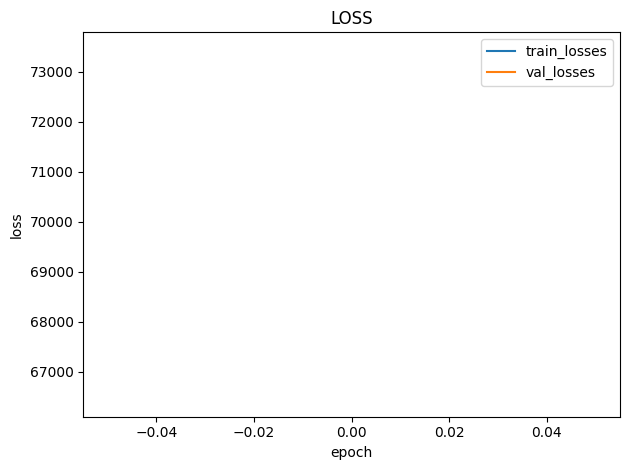

Epoch 0 [99|625] | Loss 44281.8702
44281.870185546875
[69944.9324609375, 44281.870185546875]


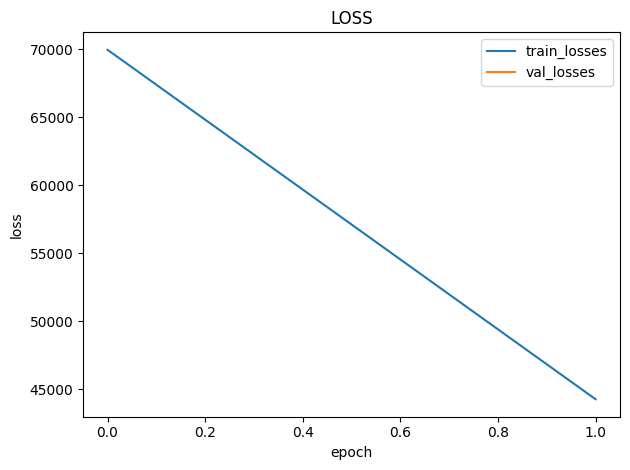

Epoch 0 [149|625] | Loss 34114.4636
34114.4636328125
[69944.9324609375, 44281.870185546875, 34114.4636328125]


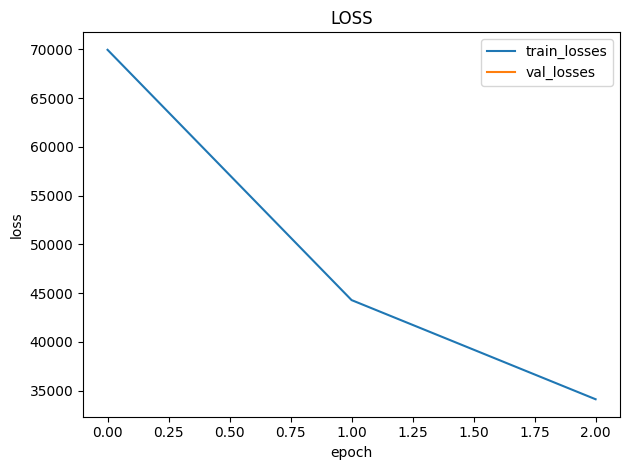

Epoch 0 [199|625] | Loss 27540.1515
27540.15147277832
[69944.9324609375, 44281.870185546875, 34114.4636328125, 27540.15147277832]


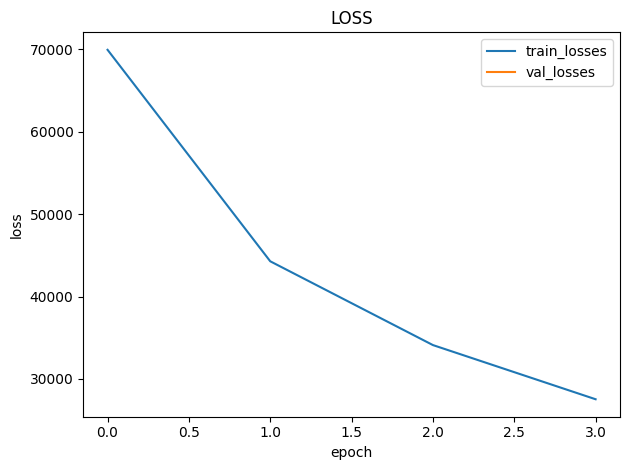

Epoch 0 [249|625] | Loss 22531.8008
22531.80080932617
[69944.9324609375, 44281.870185546875, 34114.4636328125, 27540.15147277832, 22531.80080932617]


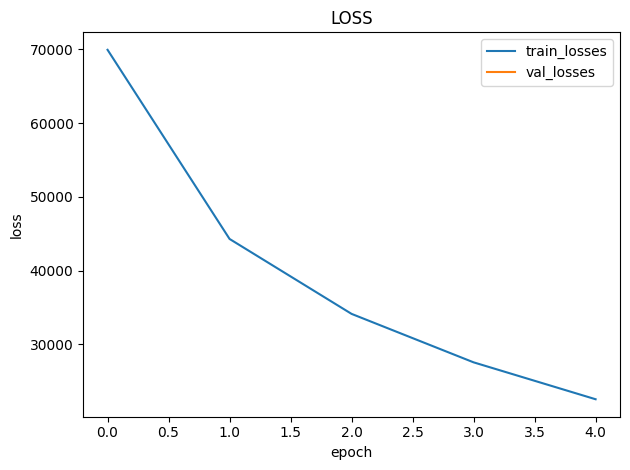

In [ ]:
# „É¢„Éá„É´„ÅÆÊßãÁØâ
model = build_vimon(config)

# Trainer„ÅÆÂàùÊúüÂåñ
trainer = Trainer(config, model, [train_loader, val_loader])

# ‰ª•Ââç„ÅÆ„ÉÅ„Çß„ÉÉ„ÇØ„Éù„Ç§„É≥„Éà„ÅÆË™≠„ÅøËæº„Åø
# checkpoint_file = '/content/drive/MyDrive/‰∏ñÁïå„É¢„Éá„É´/ÊúÄÁµÇË™≤È°å/Check/ckpt_vimon_best.pt'
# checkpoint = torch.load(os.path.join(trainer.ckpt_dir, checkpoint_file))

# # „É¢„Éá„É´„ÅÆÈáç„Åø„ÇíË™≠„ÅøËæº„Åø
# model.load_state_dict(checkpoint['model_state_dict'])

# # Optimizer„ÅÆÁä∂ÊÖã„ÇíË™≠„ÅøËæº„Åø
# trainer.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# # ‰ª•Ââç„ÅÆ„Ç®„Éù„ÉÉ„ÇØÊï∞„ÇíÂºï„ÅçÁ∂ô„Åê
# trainer.start_epoch = checkpoint['epoch'] + 1

# Êñ∞„Åó„ÅÑOptimizer„Çí‰ΩúÊàê„Åô„ÇãÂ†¥ÂêàÔºà‰æãÔºöÂ≠¶ÁøíÁéá„ÇíÂ§âÊõ¥„Åó„Åü„ÅÑÂ†¥ÂêàÔºâ
# trainer.optimizer = optim.AdamW(model.parameters(), lr=new_learning_rate)

# ÂÜçÂ≠¶Áøí„ÇíË°å„ÅÜ
print('Start training.')
trainer.train()
print('Done.')


In [35]:
save_path = '/content/drive/MyDrive/‰∏ñÁïå„É¢„Éá„É´/ÊúÄÁµÇË™≤È°å/LOSS/'
# „Éá„Éº„Çø„ÇíË™≠„ÅøËæº„ÇÄ
with open(os.path.join(save_path, f'train_losses_all_epochs.pkl'), 'rb') as f:
    loaded_train_losses = pickle.load(f)

print(loaded_train_losses)

    Epoch    Train_Loss
0       1  99457.002695
1       2  55695.274219
2       3  39049.404814
3       4  30010.916627
4       5  24190.893134
5       6  19882.361884
6       7  16629.382346
7       8  14072.507218
8       9  12001.134084
9      10  10266.272843
10     11   8791.699812
11     12   7553.351172
12     13  -6834.440166
13     14  -7249.705386
14     15  -7782.135498
15     16  -8171.639976
16     17  -8567.166986
17     18  -9019.521414
18     19  -9426.117158
19     20  -9741.897026
20     21 -10057.800833
21     22 -10339.034492
22     23 -10607.763766
23     24 -10855.059593


ÊºîÁøí‰∏≠„Å´ÂÖ®epoch„Åß„ÅÆÂ≠¶Áøí„ÇíÂÆüË°å„Åô„Çã„Åì„Å®„ÅØ„Åß„Åç„Å™„ÅÑ„ÅÆ„ÅßÔºå‰ª•Èôç„ÅÆ„Äå6. ÁµêÊûú„ÅÆÁ¢∫Ë™ç„Äç„Åß„ÅØÔºå‰∫à„ÇÅÂ≠¶Áøí„Åó„ÅüÂæå„ÅÆÈáç„Åø(`ckpt_vimon_vmds.pt`)„Çí‰ΩøÁî®„ÅóÔºåÁµêÊûú„ÇíÁ¢∫Ë™ç„Åó„Å¶„ÅÑ„Åç„Åæ„ÅôÔºé

## 5.ÁµêÊûú„ÅÆÁ¢∫Ë™ç

Â≠¶Áøí„Åó„Åü„É¢„Éá„É´„ÇíÁî®„ÅÑ„Å¶Ôºå„ÉÜ„Çπ„Éà„Éá„Éº„Çø„Åß„ÅÆÁµêÊûú„ÇíÁ¢∫Ë™ç„Åó„Åæ„ÅôÔºé

„ÉÜ„Çπ„Éà„Éá„Éº„Çø„ÅÆ‰ªªÊÑè„ÅÆ„Ç∑„Éº„É≥„Å´„Åä„Åë„ÇãÁâ©‰ΩìÂàÜÂâ≤„ÅÆ‰∫àÊ∏¨ÁµêÊûú„ÇíÔºåÂÖÉÂãïÁîª„Å®‰∏¶„Åπ„Å¶Ë°®Á§∫„Åó„Åæ„ÅôÔºé

„Åæ„Åö„ÅØ„ÉÜ„Çπ„Éà„Éá„Éº„Çø„Å®Â≠¶ÁøíÂæå„ÅÆ„É¢„Éá„É´„ÅÆÈáç„Åø„ÇíÁî®„ÅÑ„Å¶Ôºå„Éû„Çπ„ÇØ„Å®ÁîªÂÉè„ÇíÁîüÊàê„Åó„Åæ„ÅôÔºé

In [ ]:
# „Éû„Çπ„ÇØ„Å®ÁîªÂÉè„ÅÆÁîüÊàê„Å´ÂøÖË¶Å„Å™Èñ¢Êï∞„ÇíÂÆöÁæ©

def binarize_masks(masks):
    '''
    „Éû„Çπ„ÇØ„ÅÆÔºíÂÄ§Âåñ

    Parameters
    ----------
    masks : torch.Tensor ( n_slots, 1, h, w )

    Returns
    ----------
    binarized_masks : torch.Tensor ( n_slots, 1, h, w )
    '''
    n = masks.size(0)
    idc = torch.argmax(masks, dim=0)
    binarized_masks = torch.zeros_like(masks)
    for i in range(n):
        binarized_masks[i] = (idc == i).int()

    return binarized_masks


def generation_imgs(model, data, n_steps=10, n_slots=6, device=None):
    """
    ÂêÑ„Çπ„É≠„ÉÉ„Éà„ÅÆÁîªÂÉèÁîüÊàê
    """
    bs = data.size(0)
    # ÂÖ®„Çπ„É≠„ÉÉ„Éà„ÅÆ„Éû„Çπ„ÇØ„Å®ÁîªÂÉè„ÅÆÁîüÊàê
    with torch.no_grad():
        results, _ = model(data.float().to(device))
    soft_masks = results["curr_masks"].cpu()
    slot_generated_imgs = results["curr_slots"].cpu()

    # ÂêÑ„Çπ„É≠„ÉÉ„Éà„ÅÆÁîüÊàêÁîªÂÉè„Å´2ÂÄ§„Éû„Çπ„ÇØ„Çí„Åã„Åë„Çã
    for b in range(bs):
        masks_step = []
        for t in range(n_steps):
            binarized_masks = binarize_masks(soft_masks[b,t])
            slot_generated_imgs[b,t] = slot_generated_imgs[b,t] * binarized_masks # „Éû„Çπ„ÇØ„Åå„Åã„Åã„Å£„Å¶„ÅÑ„Å™„ÅÑ„Å®„Åì„Çç„ÅØ0„Å´„Åô„ÇãÔºé

    return slot_generated_imgs

In [ ]:
## „É¢„Éá„É´„Å®„Éá„Éº„Çø„Çª„ÉÉ„Éà„ÅÆË™≠„ÅøËæº„Åø
test_loader = build_testloader(
    batch_size= 8, #config['data']['batch_size'],
    num_workers=config['data']['num_workers'],
    n_steps=config['data']['n_steps']
)

# build model
model = build_vimon(config, inference=True)

# ÂÖÉÂÆüË£Ö„ÅßÂÖ¨Èñã„Åï„Çå„Å¶„ÅÑ„ÇãÂ≠¶ÁøíÊ∏à„Åø„ÅÆÈáç„Åø
ckpt = torch.load(
    os.path.join(UTILS_DIR, "lecture08_utils/ckpt_vimon_vmds.pt"),
    map_location=lambda storage, loc: storage
)
model.load_state_dict(ckpt)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


<All keys matched successfully>

In [ ]:
# „ÉÜ„Çπ„Éà„Éá„Éº„Çø„Åå‰∏é„Åà„Çâ„Çå„Åü‰∏ã„Åß„ÅÆ„Çπ„É≠„ÉÉ„Éà„Åî„Å®„ÅÆÁîªÂÉèÁîüÊàê
test_imgs = next(iter(test_loader))

slot_generated_imgs = generation_imgs(
    model,
    test_imgs,
    n_steps=config['data']['n_steps'],
    n_slots=12#config['model']['n_slots'],
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


‰∫àÊ∏¨ÁµêÊûú„ÇíË°®Á§∫„Åó„Åæ„ÅôÔºé

In [ ]:
def display_video_slots(test_imgs, slot_generated_imgs, plot_id):
    """ ÂÖÉ„Éá„Éº„Çø„Å®‰∏¶„Åπ„Å¶Ë°®Á§∫„Åô„Çã„Åü„ÇÅ„ÅÆÈñ¢Êï∞ """
    _, axes = plt.subplots(1, config["model"]["n_slots"] + 1, figsize=(12, 5))
    patches = []
    patches.append(axes[0].imshow(np.transpose(test_imgs[plot_id][0],(1,2,0))))
    axes[0].axis('off')
    for k in range(config["model"]["n_slots"]):
        patches.append(axes[k+1].imshow(np.transpose(slot_generated_imgs[plot_id][0][k],(1,2,0))))
        axes[k+1].axis('off')

    def animate(i):
        patches[0].set_data(np.transpose(test_imgs[plot_id][i],(1,2,0)))
        axes[0].set_title("Original Step %d" % (i))

        for k in range(config["model"]["n_slots"]):
          patches[k+1].set_data(np.transpose(slot_generated_imgs[plot_id][i][k],(1,2,0)))
          axes[k+1].set_title("Slot %d Step %d" % (k, i))

    anim = animation.FuncAnimation(plt.gcf(), animate, frames=config["data"]["n_steps"], interval=50)
    display(HTML(anim.to_jshtml(default_mode='once')))
    plt.close()

In [ ]:
# Ë°®Á§∫
display_video_slots(test_imgs, slot_generated_imgs, 0)

ÈÅ©Âàá„Å´Â≠¶Áøí„Åß„Åç„Å¶„ÅÑ„Çå„Å∞ÔºåÁâ©‰Ωì„Åî„Å®„ÅÆÂàÜÂâ≤„ÅåÁ¢∫Ë™ç„Åß„Åç„Çã„Å®ÊÄù„ÅÑ„Åæ„ÅôÔºé

‰ª•‰∏ä„ÅßÊºîÁøí„ÅØÁµÇ‰∫Ü„Åß„ÅôÔºé„ÅäÁñ≤„ÇåÊßò„Åß„Åó„ÅüÔºé

##6.ÂèÇËÄÉÊñáÁåÆ

[[1]](https://jmlr.org/papers/volume22/21-0199/21-0199.pdf) Marissa A. Weis, et al., "Benchmarking Unsupervised Object Representations for Video Sequences", Journal of Machine Learning Research 22 (2021) p1-61

[[2]](https://arxiv.org/abs/1901.11390)  Burgess, Christopher P., et al. "Monet: Unsupervised scene decomposition and representation." arXiv preprint arXiv:1901.11390 (2019).

[[3]](https://arxiv.org/abs/1901.07017) Watters, Nicholas, et al. "Spatial broadcast decoder: A simple architecture for learning disentangled representations in vaes." arXiv preprint arXiv:1901.07017 (2019).

[[4]](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/) Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "U-net: Convolutional networks for biomedical image segmentation." International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.
